In [26]:
%load_ext autoreload
%autoreload 2

import re
import os
from dataclasses import dataclass
import itertools
import json
import glob
os.chdir('/fsx/wpq/github/metasummer2024/external/LLaVA') # jupyter lab moving ipynb does not change !pwd properly.
import pandas as pd
import numpy as np
from rosemary.submit import shell_scripts_template, submit_job_slurm, multiline_to_singleline

log_dir = '/fsx/wpq/.slurm_log'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pretrain

In [84]:
nodes = 1; num_gpus = 8; cpu_mem = 1000; num_cpus = 96
report_to = 'wandb'
data_path = './data/liuhaotian/LLaVA-Pretrain/blip_laion_cc_sbu_558k.json'
image_folder = './data/liuhaotian/LLaVA-Pretrain/images'
train_size = None


# ablate lm/vision/projector
job_name = 'pt_1'
model_name_or_path_list = [
    './results/baselines/lmsys/vicuna-7b-v1.5',
    # './results/baselines/NousResearch/Llama-2-7b-hf',
    './results/baselines/unsloth/llama-3-8b',
]
vision_tower_list = [
    # './results/baselines/openai/clip-vit-large-patch14', # 224
    './results/baselines/openai/clip-vit-large-patch14-336',
]
mm_projector_type_list = [
    'linear',
    # 'mlp2x_gelu',
]


test_run = 0
test_run = bool(test_run)


options_list = itertools.product(
    model_name_or_path_list,
    vision_tower_list,
    mm_projector_type_list,
)
cmds = []

for (
    model_name_or_path,
    vision_tower,
    mm_projector_type,
) in options_list:
    output_dir  = f"lm={os.path.basename(model_name_or_path)}"
    output_dir += f"_vis={os.path.basename(vision_tower)}"
    output_dir += f"_mm={mm_projector_type}"
    
    output_dir = os.path.join('./results', job_name, output_dir)

    os.environ['WANDB_NAME'] = output_dir.replace('./results/', '')
    cmd = f"""
    deepspeed llava/train/train_mem.py \
        --deepspeed ./scripts/zero2.json \
        --model_name_or_path {model_name_or_path} \
        --version plain \
        --data_path {data_path} \
        --image_folder {image_folder} \
        --vision_tower {vision_tower} \
        --mm_projector_type {mm_projector_type} \
        --tune_mm_mlp_adapter True \
        --mm_vision_select_layer -2 \
        --mm_use_im_start_end False \
        --mm_use_im_patch_token False \
        --bf16 True \
        {"--train_size " + str(train_size) if train_size else ""} \
        --num_train_epochs 1 \
        --per_device_train_batch_size 32 \
        --per_device_eval_batch_size 4 \
        --gradient_accumulation_steps 1 \
        --evaluation_strategy "no" \
        --save_strategy "steps" \
        --save_steps 24000 \
        --save_total_limit 1 \
        --learning_rate 1e-3 \
        --weight_decay 0. \
        --warmup_ratio 0.03 \
        --lr_scheduler_type "cosine" \
        --logging_steps 1 \
        --tf32 True \
        --model_max_length 2048 \
        --gradient_checkpointing True \
        --dataloader_num_workers 4 \
        --lazy_preprocess True \
        --report_to {'none' if test_run else report_to} \
        --output_dir {output_dir}
    """
    
    if test_run:
        print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))
    
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    
    
    shell_scripts = shell_scripts_template.format(
        profile='/fsx/wpq/.profile_local.sh',
        conda_env='llava',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=output_dir
    )
    
    out = submit_job_slurm(
        shell_scripts,
        job_name=job_name,
        partition='learnai4p',
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        log_path=os.path.join(log_dir, '%J.out'),
        test_run=test_run,
    )
    
    print(json.dumps(out, indent=4))



[
    {
        "args": "sbatch /fsx/wpq/.sbatch/2024-06-14_19:55:02_7e16e461-1105-4850-b4b2-8865cfa77b69.sh",
        "job_id": 350567
    }
]
[
    {
        "args": "sbatch /fsx/wpq/.sbatch/2024-06-14_19:55:02_aee5550d-7aed-4a4d-8c1b-8c274bb49990.sh",
        "job_id": 350568
    }
]


## Finetune

In [92]:
nodes = 1; num_gpus = 8; cpu_mem = 1000; num_cpus = 96
report_to = 'wandb'
train_size = None # all data
data_path = './data/liuhaotian/LLaVA-Instruct-150K/llava_v1_5_mix665k.json'
image_folder = './data/'

# model_name_or_path = './results/baselines/lmsys/vicuna-7b-v1.5'
# pretrain_mm_mlp_adapter = './results/pretrain/llava-v1.5-7b/mm_projector.bin'
# vision_tower = './results/baselines/openai/clip-vit-large-patch14-336'
# mm_projector_type = 'mlp2x_gelu'

# ablate lm/vision/projector
job_name = 'sft_1'
model_name_or_path_list = [
    './results/baselines/lmsys/vicuna-7b-v1.5',
    # './results/baselines/NousResearch/Llama-2-7b-hf',
]
vision_tower_list = [
    # './results/baselines/openai/clip-vit-large-patch14', # 224
    './results/baselines/openai/clip-vit-large-patch14-336',
]
mm_projector_type_list = [
    'linear',
    # 'mlp2x_gelu',
]


test_run = 1
test_run = bool(test_run)


options_list = itertools.product(
    model_name_or_path_list,
    vision_tower_list,
    mm_projector_type_list,
)

cmds = []


for (
    model_name_or_path,
    vision_tower,
    mm_projector_type,
) in options_list:
    output_dir  = f"lm={os.path.basename(model_name_or_path)}"
    output_dir += f"_vis={os.path.basename(vision_tower)}"
    output_dir += f"_mm={mm_projector_type}"
    
    output_dir = os.path.join('./results', job_name, output_dir)

    mm_adaptor_job_dir = output_dir.replace(job_name, job_name.replace('sft', 'pt'))
    pretrain_mm_mlp_adapter = os.path.join(mm_adaptor_job_dir, 'mm_projector.bin')
    if not os.path.isfile(pretrain_mm_mlp_adapter):
        raise ValueError(f'{pretrain_mm_mlp_adapter} does not exists.')

    os.environ['WANDB_NAME'] = output_dir.replace('./results/', '')

    cmd = f"""
    deepspeed llava/train/train_mem.py \
        --deepspeed ./scripts/zero3.json \
        --model_name_or_path {model_name_or_path} \
        --version v1 \
        --data_path {data_path} \
        --image_folder {image_folder} \
        --vision_tower {vision_tower} \
        --pretrain_mm_mlp_adapter {pretrain_mm_mlp_adapter} \
        --mm_projector_type {mm_projector_type} \
        --mm_vision_select_layer -2 \
        --mm_use_im_start_end False \
        --mm_use_im_patch_token False \
        --image_aspect_ratio pad \
        --group_by_modality_length True \
        --bf16 True \
        {"--train_size " + str(train_size) if train_size else ""} \
        --num_train_epochs 1 \
        --per_device_train_batch_size 16 \
        --per_device_eval_batch_size 4 \
        --gradient_accumulation_steps 1 \
        --evaluation_strategy "no" \
        --save_strategy "steps" \
        --save_steps 50000 \
        --save_total_limit 1 \
        --learning_rate 2e-5 \
        --weight_decay 0. \
        --warmup_ratio 0.03 \
        --lr_scheduler_type "cosine" \
        --logging_steps 1 \
        --tf32 True \
        --model_max_length 2048 \
        --gradient_checkpointing True \
        --dataloader_num_workers 4 \
        --lazy_preprocess True \
        --report_to {'none' if test_run else report_to} \
        --output_dir {output_dir}
    """
    
    if test_run:
        print('\n'+' \\\n\t'.join([x.strip() for x in re.split(r'\s{3,}', cmd)]))
    
    cmd = multiline_to_singleline(cmd)
    cmds.append(cmd)
    
    
    shell_scripts = shell_scripts_template.format(
        profile='/fsx/wpq/.profile_local.sh',
        conda_env='llava',
        cwd=os.getcwd(),
        cmd=cmd,
        log_dir=log_dir,
        save_dir=output_dir
    )
    
    out = submit_job_slurm(
        shell_scripts,
        job_name=job_name,
        partition='learnai4p',
        nodes=nodes,
        num_cpus=num_cpus,
        cpu_mem=cpu_mem,
        num_gpus=num_gpus,
        log_path=os.path.join(log_dir, '%J.out'),
        test_run=test_run,
    )
    
    print(json.dumps(out, indent=4))

[
    {
        "args": "sbatch /fsx/wpq/.sbatch/2024-06-14_19:58:29_4af75f7a-f59d-4a70-90df-d1dcb986bfce.sh",
        "job_id": 350573
    }
]


ls: cannot access './results/pt_1/lm=Llama-2-7b-hf_vis=clip-vit-large-patch14_mm=mlp2x_gelu/': No such file or directory


## Evaluations

In [3]:
from utils import download_eval_server_results
download_eval_server_results('./eval_server_results.csv', verbose=True)

In [43]:
from rosemary.submit import submit_job_slurm
nodes = 1; num_gpus = 8; cpu_mem = 1000; num_cpus = 96

eval_script_dir = 'scripts/v1_5/eval_mod'
eval_rest = True
eval_dirs = []
subdir_path_list = []
subdir_filter_fn = lambda x: True


task_names_vqa = ['vqav2', 'gqa', 'vizwiz', 'textvqa', 'scienceqa']
task_names_sft = ['pope', 'mme', 'mmbench', 'seed', 'llavabench', 'mmvet']
task_names_all = task_names_vqa + task_names_sft
task_names_routine = ['vqav2', 'gqa', 'vizwiz', 'textvqa', 'scienceqa', 'pope', 'mme', 'mmbench',]
task_names_llm_evaluator = ['llavabench', 'mmvet']

######

# ## baselines
# subdir_path_list = [
#     'results/baselines/liuhaotian/llava-v1.5-7b',
# ]
# task_names = ['llavabench']
# eval_rest = False

## sft_1
exp_dirs = ['results/sft_1']
task_names = ['scienceqa']
eval_rest = False



######

test_run = 0
test_run = bool(test_run)

if len(subdir_path_list)==0:
    subdir_path_list = []
    for exp_dir in exp_dirs:
        subdirs = list(os.listdir(exp_dir))
        subdirs = filter(subdir_filter_fn, subdirs)
        for subdir in subdirs:
            subdir_path = os.path.join(exp_dir, subdir)
            if not os.path.isfile(os.path.join(subdir_path, 'config.json')): # skip runs not yet finished
                continue
            subdir_path_list.append(subdir_path)

@dataclass
class TaskConfig:
    task_finish_proof: str
    num_gpus: int
    bash_script_name: str

task_configs = {
    'vqav2': TaskConfig('*/answers_upload.json', 8, 'vqav2'),
    'gqa': TaskConfig('*/*_predictions.json', 8, 'gqa'),
    'vizwiz': TaskConfig('answers_upload.json', 1, 'vizwiz'),
    'textvqa': TaskConfig('answers.jsonl', 1, 'textvqa'),
    'scienceqa': TaskConfig('results.jsonl', 1, 'sqa'),
    'pope': TaskConfig('answers.jsonl', 1, 'pope'),
    'mme': TaskConfig('results', 1, 'mme'),
    'mmbench': TaskConfig('*.xlsx', 1, 'mmbench'),
    'mmvet': TaskConfig('results_*.csv', 1, 'mmvet'),
    'seed': TaskConfig('answers_upload.jsonl', 8, 'seed'),
    'llavabench': TaskConfig('reviews.jsonl', 1, 'llavabench'),
}

if eval_rest:
    task_name_and_model = []
    for subdir_path in subdir_path_list:
        for task_name in task_names:
            if not glob.glob(os.path.join(subdir_path, 'eval', task_name, task_configs[task_name].task_finish_proof)):
                task_name_and_model.append((task_name, subdir_path))
else:
    task_name_and_model = list(itertools.product(task_names, subdir_path_list))
    
print('cmds: #=', len(list(task_name_and_model)))
print(list(task_name_and_model), '\n\n')


dfo = pd.DataFrame(task_name_and_model, columns=['task_name', 'model_name_or_path'])
model_and_task_list = dfo.groupby('model_name_or_path')['task_name'].agg(list).to_dict()

cmds = []
for model_name_or_path, task_name_list in model_and_task_list.items():
    model_name_or_path = model_name_or_path.rstrip('/')
    for i, task_name in enumerate(task_name_list):
        task_config = task_configs[task_name]
        job_name = f'eval.{task_name}'
        save_dir = f'{model_name_or_path}/eval/{task_name}'
        os.makedirs(save_dir, exist_ok=True)

        if task_name.startswith(tuple(task_configs.keys())):
            cmd = f"bash {eval_script_dir}/{task_config.bash_script_name}.sh {model_name_or_path} > {os.path.join(save_dir,'bash_script_log.txt')}"
        else:
            raise ValueError(f'{task_name} not supported.')

        num_gpus = task_config.num_gpus            
        cmd = multiline_to_singleline(cmd)
        cmds.append(cmd)
        
        shell_scripts = shell_scripts_template.format(
            profile='/fsx/wpq/.profile_local.sh',
            conda_env='llava',
            cwd=os.getcwd(),
            cmd=cmd,
            log_dir=log_dir,
            save_dir=save_dir
        )
        out = submit_job_slurm(
            shell_scripts, 
            job_name=job_name,
            partition='learnai4p',
            nodes=nodes,
            num_cpus=num_cpus,
            cpu_mem=cpu_mem,
            num_gpus=num_gpus,
        log_path=os.path.join(log_dir, '%J.out'),
            test_run=test_run,
        )
        for x in out:
            x.update({'cmd': cmd})

        print(json.dumps(out[0], indent=4))

cmds: #= 1
[('scienceqa', 'results/baselines/liuhaotian/llava-v1.5-7b')] 


{
    "args": "sbatch /fsx/wpq/.sbatch/2024-06-14_18:18:34_70c5b73b-bb20-44b0-a042-d88c09443e73.sh",
    "job_id": 350562,
    "cmd": "bash scripts/v1_5/eval_mod/sqa.sh results/baselines/liuhaotian/llava-v1.5-7b > results/baselines/liuhaotian/llava-v1.5-7b/eval/scienceqa/bash_script_log.txt"
}


## Eval Results

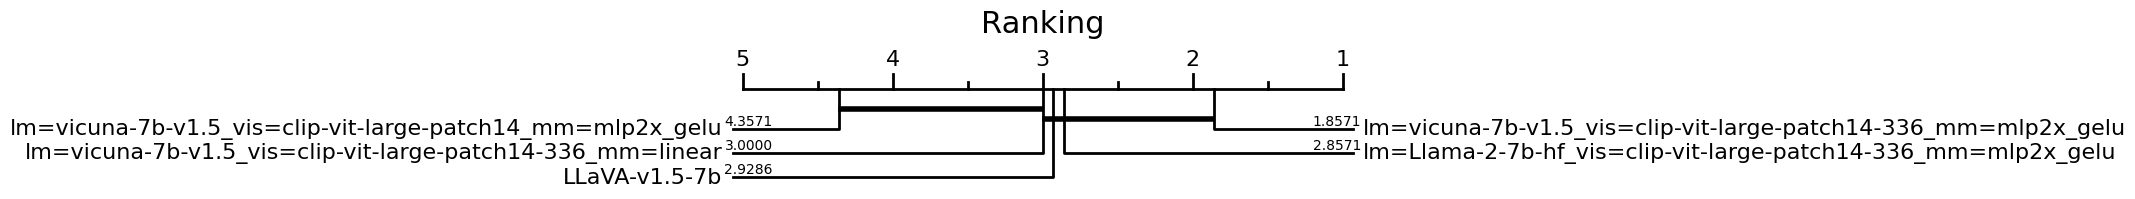

,run_name,Base LM,Resolution,Projector,VQAv2,GQA,VizWiz,ScienceQA,TextVQA,POPE,MME,Ranking
0,lm=vicuna-7b-v1.5_vis=clip-vit-large-patch14-336_mm=mlp2x_gelu,vicuna-7b-v1.5,336,mlp2x_gelu,79.1,62.7,50.9,69.3,59.2,86.6,1462.0,1.9
1,lm=Llama-2-7b-hf_vis=clip-vit-large-patch14-336_mm=mlp2x_gelu,Llama-2-7b-hf,336,mlp2x_gelu,79.1,62.7,54.3,67.8,57.6,86.3,1474.1,2.9
2,LLaVA-v1.5-7b,vicuna-7b-v1.5,336,mlp2x_gelu,78.5,62.0,50.0,69.5,58.2,85.9,1506.8,2.9
3,lm=vicuna-7b-v1.5_vis=clip-vit-large-patch14-336_mm=linear,vicuna-7b-v1.5,336,linear,78.7,62.4,46.9,69.0,58.0,86.3,1517.5,3.0
4,lm=vicuna-7b-v1.5_vis=clip-vit-large-patch14_mm=mlp2x_gelu,vicuna-7b-v1.5,224,mlp2x_gelu,77.3,61.5,48.4,69.5,54.8,84.2,1436.5,4.4


In [156]:
from utils import TaskResult, ModelResult, get_eval_results
from cd_diagram import draw_cd_diagram

save_dirs = []
save_dirs += [('LLaVA-v1.5-7b', 'results/baselines/liuhaotian/llava-v1.5-7b')]
exp_dir = 'results/sft_1'
save_dirs += [(os.path.basename(x), x) for x in [os.path.join(exp_dir, x) for x in os.listdir(exp_dir)]]

configs_name = [
    'run_name', 'Base LM', 'Resolution', 'Projector',
]
metrics_names = [
    'VQAv2/acc', 'GQA/acc', 'VizWiz/acc', 'ScienceQA/acc', 'TextVQA/acc', 'POPE/F1-score', 'MME/perception', # 'MMBench/acc', 'LLaVA/all', 'MM-Vet/score'
]

df = get_eval_results(save_dirs, configs_name+metrics_names)

dfm = df[['run_name']+metrics_names]
dfm = pd.melt(dfm, id_vars=['run_name'], var_name='dataset_name', value_name='accuracy')
dfm = dfm.rename(columns={'run_name': 'classifier_name'})
cd_info = draw_cd_diagram(dfm, title='Ranking', labels=True, alpha=.1)
df['Ranking'] = df['run_name'].map(cd_info['average_ranks'])
df = df.sort_values(by=['Ranking'], ascending=True).reset_index(drop=True)
df.columns = [x.split('/')[0] for x in df.columns]

plt.show(fig)
display(df
    .style
    .set_table_styles([{'selector': 'td', 'props': [('white-space', 'pre-wrap'), ('word-wrap', 'break-word')]}])
    .set_properties(**{'text-align': 'left'})
    .background_gradient(cmap='RdYlGn', subset=[col for col in df.select_dtypes(include=[np.number]).columns if col != 'Ranking'], low=.2, high=.8)
    .background_gradient(cmap='RdYlGn_r', subset=['Ranking'], low=.2, high=.8)
    .format(precision=1))